# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

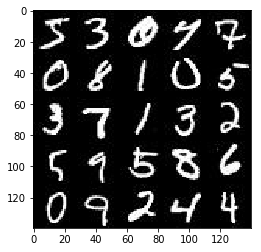

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

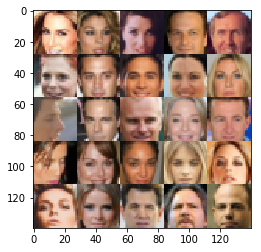

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


c:\rain\software\anaconda3_64\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
def lrelu(x, alpha):
    return tf.maximum(x * alpha, x)

### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [7]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        # 14x14x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        # 7x7x128
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        # 4x4x256
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 7x7x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 14x14x128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, kernel_initializer=kinit, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_real_out, d_real_logits = discriminator(input_real, alpha=alpha)
    d_fake_out, d_fake_logits = discriminator(g_model, reuse=True, alpha=alpha)
    
    smooth = 0.1
    real_labels = tf.ones_like(d_real_out) * (1 - smooth)
    fake_labels = tf.zeros_like(d_fake_out)
    g_labels    = tf.ones_like(d_fake_out)

    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=real_labels))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=fake_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=g_labels))

    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [12]:
# def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.7387... Generator Loss: 1.3396
Epoch 1/2... Discriminator Loss: 0.4852... Generator Loss: 2.4490
Epoch 1/2... Discriminator Loss: 0.4670... Generator Loss: 2.6336
Epoch 1/2... Discriminator Loss: 0.4094... Generator Loss: 3.5800
Epoch 1/2... Discriminator Loss: 0.3765... Generator Loss: 3.7713
Epoch 1/2... Discriminator Loss: 0.3759... Generator Loss: 3.8190
Epoch 1/2... Discriminator Loss: 0.3703... Generator Loss: 4.1296
Epoch 1/2... Discriminator Loss: 0.3556... Generator Loss: 5.0035
Epoch 1/2... Discriminator Loss: 0.3552... Generator Loss: 4.6239
Epoch 1/2... Discriminator Loss: 0.3676... Generator Loss: 3.8954


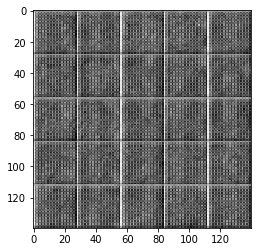

Epoch 1/2... Discriminator Loss: 0.3771... Generator Loss: 3.8895
Epoch 1/2... Discriminator Loss: 0.3814... Generator Loss: 4.5576
Epoch 1/2... Discriminator Loss: 0.4505... Generator Loss: 3.9617
Epoch 1/2... Discriminator Loss: 0.3641... Generator Loss: 4.8747
Epoch 1/2... Discriminator Loss: 0.3655... Generator Loss: 4.1774
Epoch 1/2... Discriminator Loss: 0.3883... Generator Loss: 4.0238
Epoch 1/2... Discriminator Loss: 0.4202... Generator Loss: 3.8121
Epoch 1/2... Discriminator Loss: 0.7697... Generator Loss: 2.5126
Epoch 1/2... Discriminator Loss: 0.3634... Generator Loss: 4.0604
Epoch 1/2... Discriminator Loss: 0.5853... Generator Loss: 3.2100


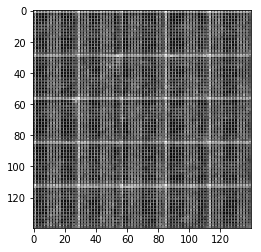

Epoch 1/2... Discriminator Loss: 0.4340... Generator Loss: 2.8294
Epoch 1/2... Discriminator Loss: 2.7962... Generator Loss: 0.2006
Epoch 1/2... Discriminator Loss: 0.4767... Generator Loss: 2.4700
Epoch 1/2... Discriminator Loss: 0.5815... Generator Loss: 1.6958
Epoch 1/2... Discriminator Loss: 0.3944... Generator Loss: 3.3023
Epoch 1/2... Discriminator Loss: 0.4066... Generator Loss: 3.6502
Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 0.6340
Epoch 1/2... Discriminator Loss: 0.5174... Generator Loss: 2.1334
Epoch 1/2... Discriminator Loss: 0.6111... Generator Loss: 3.0178
Epoch 1/2... Discriminator Loss: 0.6279... Generator Loss: 1.6144


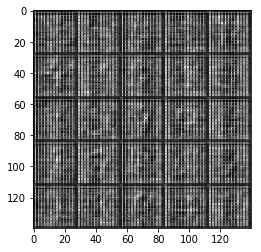

Epoch 1/2... Discriminator Loss: 0.5059... Generator Loss: 2.4027
Epoch 1/2... Discriminator Loss: 0.7496... Generator Loss: 1.9259
Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 3.4776
Epoch 1/2... Discriminator Loss: 0.4993... Generator Loss: 2.4306
Epoch 1/2... Discriminator Loss: 0.5787... Generator Loss: 2.2787
Epoch 1/2... Discriminator Loss: 0.7037... Generator Loss: 2.5611
Epoch 1/2... Discriminator Loss: 0.7058... Generator Loss: 1.3997
Epoch 1/2... Discriminator Loss: 0.6478... Generator Loss: 2.7847
Epoch 1/2... Discriminator Loss: 0.8461... Generator Loss: 1.3312
Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 1.4187


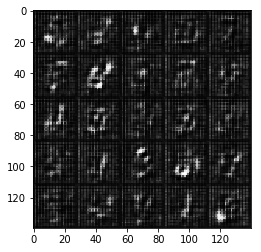

Epoch 1/2... Discriminator Loss: 0.5830... Generator Loss: 1.9922
Epoch 1/2... Discriminator Loss: 0.7228... Generator Loss: 2.4679
Epoch 1/2... Discriminator Loss: 0.8540... Generator Loss: 2.7245
Epoch 1/2... Discriminator Loss: 0.6593... Generator Loss: 1.6768
Epoch 1/2... Discriminator Loss: 0.5903... Generator Loss: 2.0762
Epoch 1/2... Discriminator Loss: 0.6307... Generator Loss: 2.2477
Epoch 1/2... Discriminator Loss: 0.7384... Generator Loss: 1.8999
Epoch 1/2... Discriminator Loss: 0.6232... Generator Loss: 2.0306
Epoch 1/2... Discriminator Loss: 0.7346... Generator Loss: 2.2823
Epoch 1/2... Discriminator Loss: 0.5760... Generator Loss: 2.0489


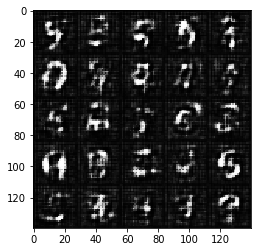

Epoch 1/2... Discriminator Loss: 0.7463... Generator Loss: 1.8703
Epoch 1/2... Discriminator Loss: 0.6662... Generator Loss: 1.7717
Epoch 1/2... Discriminator Loss: 0.6754... Generator Loss: 2.3061
Epoch 1/2... Discriminator Loss: 0.5877... Generator Loss: 1.8435
Epoch 1/2... Discriminator Loss: 0.6931... Generator Loss: 2.9099
Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 0.7956
Epoch 1/2... Discriminator Loss: 0.8715... Generator Loss: 1.1310
Epoch 1/2... Discriminator Loss: 0.6057... Generator Loss: 1.8583
Epoch 1/2... Discriminator Loss: 0.8067... Generator Loss: 1.1610
Epoch 1/2... Discriminator Loss: 0.5881... Generator Loss: 2.2739


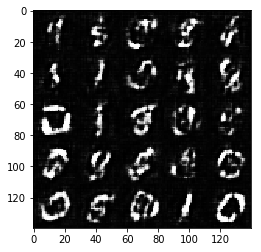

Epoch 1/2... Discriminator Loss: 0.6867... Generator Loss: 1.5229
Epoch 1/2... Discriminator Loss: 0.6039... Generator Loss: 1.8446
Epoch 1/2... Discriminator Loss: 0.7133... Generator Loss: 1.6010
Epoch 1/2... Discriminator Loss: 0.5887... Generator Loss: 2.2412
Epoch 1/2... Discriminator Loss: 0.7414... Generator Loss: 1.4021
Epoch 1/2... Discriminator Loss: 0.8230... Generator Loss: 1.2719
Epoch 1/2... Discriminator Loss: 0.6480... Generator Loss: 1.8112
Epoch 1/2... Discriminator Loss: 0.8102... Generator Loss: 1.8538
Epoch 1/2... Discriminator Loss: 0.6728... Generator Loss: 1.5202
Epoch 1/2... Discriminator Loss: 0.7091... Generator Loss: 1.7877


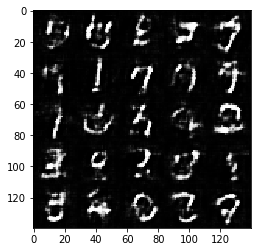

Epoch 1/2... Discriminator Loss: 1.4410... Generator Loss: 0.5522
Epoch 1/2... Discriminator Loss: 0.6837... Generator Loss: 1.6996
Epoch 1/2... Discriminator Loss: 0.8053... Generator Loss: 1.9126
Epoch 1/2... Discriminator Loss: 0.6483... Generator Loss: 1.7773
Epoch 1/2... Discriminator Loss: 0.7077... Generator Loss: 1.6247
Epoch 1/2... Discriminator Loss: 0.7368... Generator Loss: 1.6951
Epoch 1/2... Discriminator Loss: 1.0514... Generator Loss: 2.4340
Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 0.8233
Epoch 1/2... Discriminator Loss: 0.9020... Generator Loss: 1.0614
Epoch 1/2... Discriminator Loss: 0.8458... Generator Loss: 1.1847


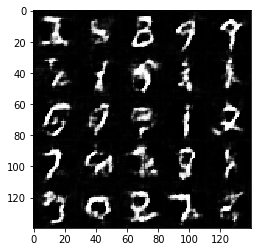

Epoch 1/2... Discriminator Loss: 0.7607... Generator Loss: 1.5605
Epoch 1/2... Discriminator Loss: 0.7394... Generator Loss: 1.6579
Epoch 1/2... Discriminator Loss: 0.6917... Generator Loss: 1.7400
Epoch 1/2... Discriminator Loss: 0.6311... Generator Loss: 1.9939
Epoch 1/2... Discriminator Loss: 0.7275... Generator Loss: 1.6621
Epoch 1/2... Discriminator Loss: 0.8676... Generator Loss: 1.5434
Epoch 1/2... Discriminator Loss: 0.9915... Generator Loss: 1.7848
Epoch 1/2... Discriminator Loss: 0.7370... Generator Loss: 1.4078
Epoch 1/2... Discriminator Loss: 0.9563... Generator Loss: 2.1065
Epoch 1/2... Discriminator Loss: 0.9775... Generator Loss: 1.0218


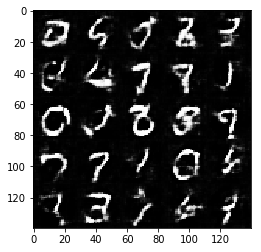

Epoch 1/2... Discriminator Loss: 0.9055... Generator Loss: 1.1075
Epoch 1/2... Discriminator Loss: 0.8494... Generator Loss: 1.3861
Epoch 1/2... Discriminator Loss: 0.8473... Generator Loss: 1.2936
Epoch 2/2... Discriminator Loss: 0.9480... Generator Loss: 0.9548
Epoch 2/2... Discriminator Loss: 0.6530... Generator Loss: 1.7545
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.2491
Epoch 2/2... Discriminator Loss: 0.9144... Generator Loss: 1.2114
Epoch 2/2... Discriminator Loss: 0.9357... Generator Loss: 1.4615
Epoch 2/2... Discriminator Loss: 1.0658... Generator Loss: 2.0240
Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 1.1949


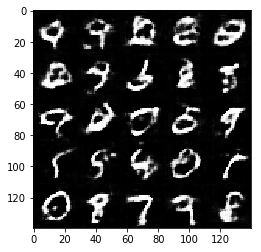

Epoch 2/2... Discriminator Loss: 0.7855... Generator Loss: 1.5626
Epoch 2/2... Discriminator Loss: 0.7464... Generator Loss: 1.8533
Epoch 2/2... Discriminator Loss: 0.8615... Generator Loss: 1.1230
Epoch 2/2... Discriminator Loss: 0.9992... Generator Loss: 0.8901
Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 2.2880
Epoch 2/2... Discriminator Loss: 1.0010... Generator Loss: 1.0193
Epoch 2/2... Discriminator Loss: 0.8651... Generator Loss: 1.6926
Epoch 2/2... Discriminator Loss: 0.9770... Generator Loss: 0.8772
Epoch 2/2... Discriminator Loss: 0.8351... Generator Loss: 1.3761
Epoch 2/2... Discriminator Loss: 1.0421... Generator Loss: 0.8024


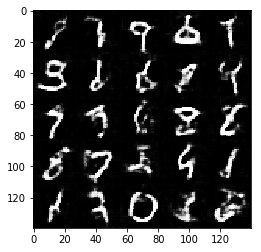

Epoch 2/2... Discriminator Loss: 0.7448... Generator Loss: 1.5704
Epoch 2/2... Discriminator Loss: 0.7326... Generator Loss: 1.8968
Epoch 2/2... Discriminator Loss: 0.7153... Generator Loss: 1.5338
Epoch 2/2... Discriminator Loss: 0.8232... Generator Loss: 1.9171
Epoch 2/2... Discriminator Loss: 1.0482... Generator Loss: 0.8885
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.3773
Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 1.4727
Epoch 2/2... Discriminator Loss: 1.0101... Generator Loss: 0.9110
Epoch 2/2... Discriminator Loss: 0.8952... Generator Loss: 1.2752
Epoch 2/2... Discriminator Loss: 0.7987... Generator Loss: 1.2936


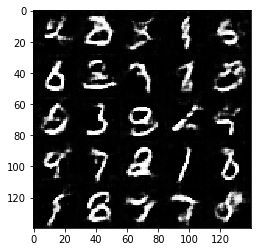

Epoch 2/2... Discriminator Loss: 0.7871... Generator Loss: 1.7016
Epoch 2/2... Discriminator Loss: 1.0019... Generator Loss: 2.4017
Epoch 2/2... Discriminator Loss: 0.8251... Generator Loss: 1.2804
Epoch 2/2... Discriminator Loss: 0.8871... Generator Loss: 1.1430
Epoch 2/2... Discriminator Loss: 1.0419... Generator Loss: 0.8770
Epoch 2/2... Discriminator Loss: 0.9903... Generator Loss: 2.0917
Epoch 2/2... Discriminator Loss: 0.8482... Generator Loss: 1.4506
Epoch 2/2... Discriminator Loss: 1.0889... Generator Loss: 0.7962
Epoch 2/2... Discriminator Loss: 0.7716... Generator Loss: 1.4035
Epoch 2/2... Discriminator Loss: 0.8442... Generator Loss: 1.5757


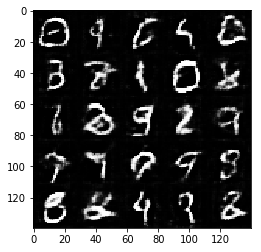

Epoch 2/2... Discriminator Loss: 0.7537... Generator Loss: 1.4255
Epoch 2/2... Discriminator Loss: 1.0176... Generator Loss: 0.9485
Epoch 2/2... Discriminator Loss: 0.9122... Generator Loss: 1.0012
Epoch 2/2... Discriminator Loss: 0.8105... Generator Loss: 2.1394
Epoch 2/2... Discriminator Loss: 1.0019... Generator Loss: 0.9581
Epoch 2/2... Discriminator Loss: 0.8499... Generator Loss: 1.2042
Epoch 2/2... Discriminator Loss: 0.7940... Generator Loss: 1.5221
Epoch 2/2... Discriminator Loss: 0.6766... Generator Loss: 1.7498
Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 2.2935
Epoch 2/2... Discriminator Loss: 0.8250... Generator Loss: 1.8516


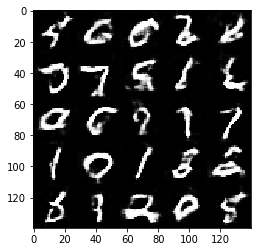

Epoch 2/2... Discriminator Loss: 0.8161... Generator Loss: 1.2992
Epoch 2/2... Discriminator Loss: 0.8394... Generator Loss: 1.2332
Epoch 2/2... Discriminator Loss: 1.3482... Generator Loss: 0.6076
Epoch 2/2... Discriminator Loss: 0.7548... Generator Loss: 1.3700
Epoch 2/2... Discriminator Loss: 0.8824... Generator Loss: 1.9606
Epoch 2/2... Discriminator Loss: 0.8517... Generator Loss: 1.2435
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 1.2283
Epoch 2/2... Discriminator Loss: 0.9433... Generator Loss: 1.0986
Epoch 2/2... Discriminator Loss: 0.6592... Generator Loss: 1.8565
Epoch 2/2... Discriminator Loss: 0.7986... Generator Loss: 2.0378


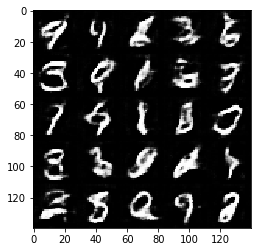

Epoch 2/2... Discriminator Loss: 1.3229... Generator Loss: 0.5917
Epoch 2/2... Discriminator Loss: 0.7239... Generator Loss: 1.4278
Epoch 2/2... Discriminator Loss: 0.7245... Generator Loss: 1.4478
Epoch 2/2... Discriminator Loss: 0.8096... Generator Loss: 1.4506
Epoch 2/2... Discriminator Loss: 0.7590... Generator Loss: 1.5128
Epoch 2/2... Discriminator Loss: 0.8634... Generator Loss: 1.7968
Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 1.1549
Epoch 2/2... Discriminator Loss: 0.8295... Generator Loss: 1.8922
Epoch 2/2... Discriminator Loss: 1.2256... Generator Loss: 0.6534
Epoch 2/2... Discriminator Loss: 0.7167... Generator Loss: 1.6390


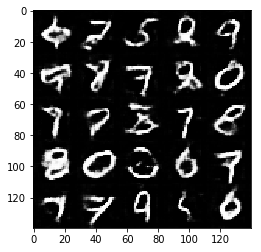

Epoch 2/2... Discriminator Loss: 0.9979... Generator Loss: 0.9701
Epoch 2/2... Discriminator Loss: 0.8034... Generator Loss: 1.4196
Epoch 2/2... Discriminator Loss: 0.9001... Generator Loss: 1.0503
Epoch 2/2... Discriminator Loss: 0.8261... Generator Loss: 1.3036
Epoch 2/2... Discriminator Loss: 0.7533... Generator Loss: 1.9054
Epoch 2/2... Discriminator Loss: 0.7416... Generator Loss: 1.8486
Epoch 2/2... Discriminator Loss: 0.7162... Generator Loss: 1.5390
Epoch 2/2... Discriminator Loss: 0.7863... Generator Loss: 1.2337
Epoch 2/2... Discriminator Loss: 0.7942... Generator Loss: 1.3979
Epoch 2/2... Discriminator Loss: 1.1687... Generator Loss: 0.6528


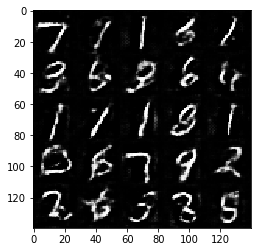

Epoch 2/2... Discriminator Loss: 0.8310... Generator Loss: 1.2972
Epoch 2/2... Discriminator Loss: 1.1624... Generator Loss: 0.7084
Epoch 2/2... Discriminator Loss: 0.8285... Generator Loss: 1.2319
Epoch 2/2... Discriminator Loss: 0.8332... Generator Loss: 1.3578
Epoch 2/2... Discriminator Loss: 0.7299... Generator Loss: 1.5948
Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 1.3177
Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.4219
Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 1.5582
Epoch 2/2... Discriminator Loss: 0.5699... Generator Loss: 2.2332
Epoch 2/2... Discriminator Loss: 0.7951... Generator Loss: 2.0312


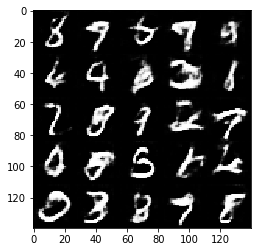

Epoch 2/2... Discriminator Loss: 0.9100... Generator Loss: 1.2261
Epoch 2/2... Discriminator Loss: 0.9750... Generator Loss: 0.9207
Epoch 2/2... Discriminator Loss: 0.7035... Generator Loss: 2.0943
Epoch 2/2... Discriminator Loss: 0.7756... Generator Loss: 1.4146
Epoch 2/2... Discriminator Loss: 0.7021... Generator Loss: 1.4529
Epoch 2/2... Discriminator Loss: 0.7497... Generator Loss: 1.3968
Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 1.3217


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 1.9256... Generator Loss: 0.4074
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.7150... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 0.5499... Generator Loss: 2.3298
Epoch 1/1... Discriminator Loss: 0.6412... Generator Loss: 1.6445
Epoch 1/1... Discriminator Loss: 0.4154... Generator Loss: 3.3094
Epoch 1/1... Discriminator Loss: 0.5513... Generator Loss: 4.2088
Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 4.8056
Epoch 1/1... Discriminator Loss: 0.6444... Generator Loss: 2.9841
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 1.1037


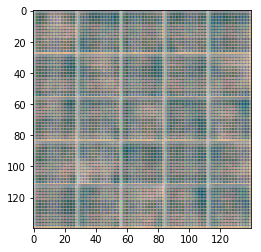

Epoch 1/1... Discriminator Loss: 3.2434... Generator Loss: 0.1196
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 1.7358
Epoch 1/1... Discriminator Loss: 1.5376... Generator Loss: 4.4290
Epoch 1/1... Discriminator Loss: 2.4180... Generator Loss: 0.1848
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 0.7492... Generator Loss: 2.1326
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 1.8317
Epoch 1/1... Discriminator Loss: 1.8881... Generator Loss: 0.2964
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.5370


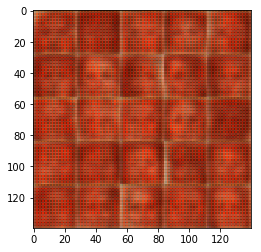

Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 1.2279
Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 1.7149
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 1.9872
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 1.7549
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 1.5083
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 2.2804
Epoch 1/1... Discriminator Loss: 1.9910... Generator Loss: 0.2798
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.5171


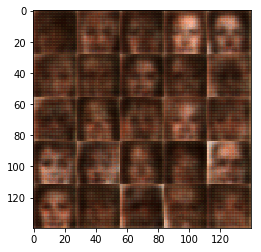

Epoch 1/1... Discriminator Loss: 1.7105... Generator Loss: 0.4246
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.9185
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 2.4292
Epoch 1/1... Discriminator Loss: 1.6324... Generator Loss: 1.8160
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 1.1288
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 1.4178


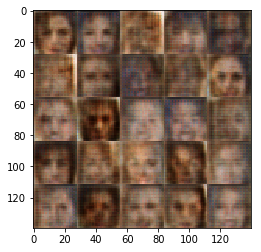

Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 1.1674
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 1.1477
Epoch 1/1... Discriminator Loss: 1.6770... Generator Loss: 2.1984
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.6480
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 1.7627... Generator Loss: 0.5381
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 1.2071


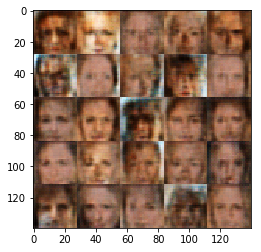

Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 1.5094
Epoch 1/1... Discriminator Loss: 1.6727... Generator Loss: 0.4762
Epoch 1/1... Discriminator Loss: 1.5968... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.7786... Generator Loss: 0.3259


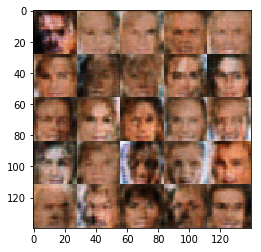

Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 1.4733
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 1.7615... Generator Loss: 0.3644
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 1.1893
Epoch 1/1... Discriminator Loss: 1.8950... Generator Loss: 0.2938
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.7121


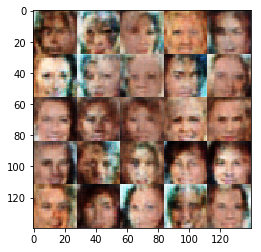

Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.8792


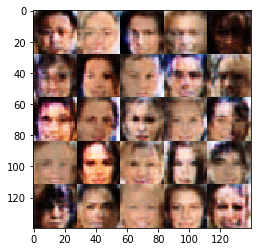

Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.5215
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 1.1982
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.7523


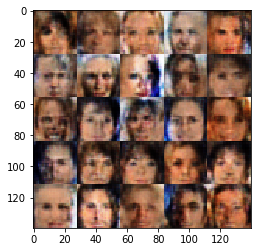

Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.2651
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 1.4818
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.8614


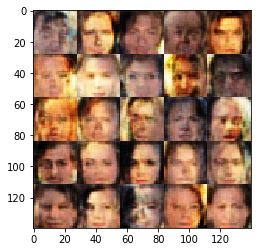

Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 1.1587
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 1.2397
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.7534


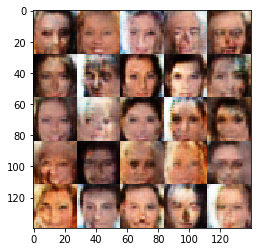

Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 1.3022
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.8445


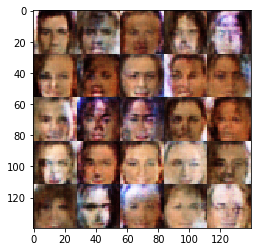

Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 1.1894
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.1863
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.5990


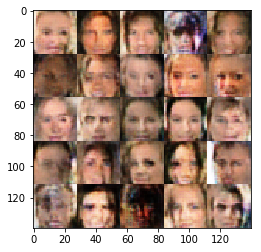

Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 1.1292
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.7199


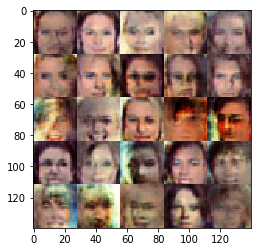

Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.8622


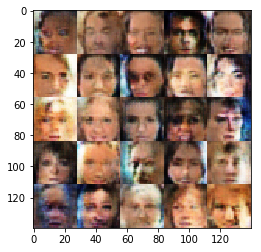

Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.6678


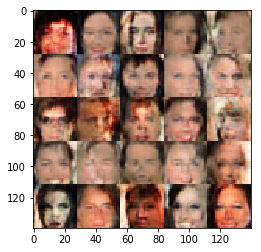

Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.6044


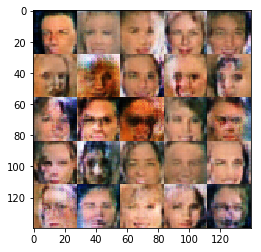

Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.7598... Generator Loss: 0.4212
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.8030


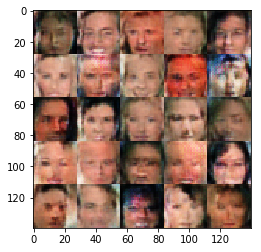

Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 1.2292


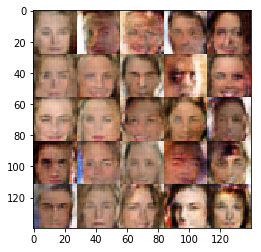

Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.6247... Generator Loss: 0.4466
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 1.1512
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.3733
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.0290


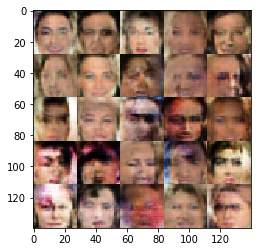

Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.9588


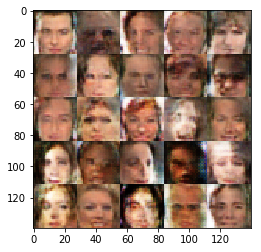

Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 1.1533
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.5029
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.6351... Generator Loss: 0.3991
Epoch 1/1... Discriminator Loss: 1.6594... Generator Loss: 0.4000


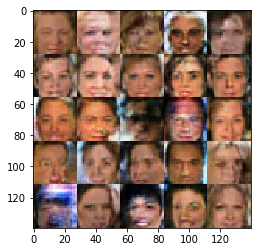

Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.5381
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 1.2155
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.9034


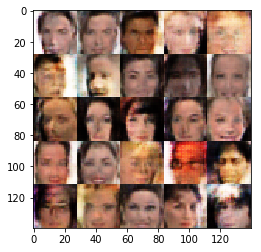

Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.5351
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 0.9916


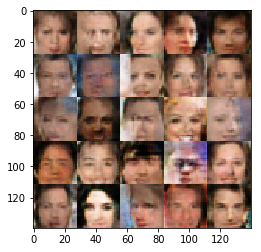

Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.4630
Epoch 1/1... Discriminator Loss: 1.6729... Generator Loss: 0.4034
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.1790
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.5092
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.5342


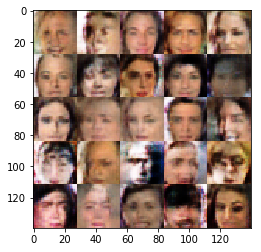

Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 1.1878
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.4670


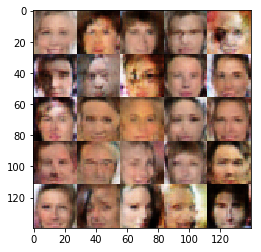

Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.7643... Generator Loss: 0.3411
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 1.0555


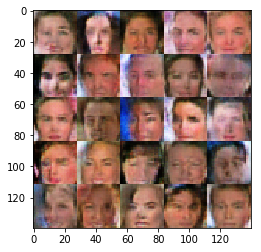

Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.9201


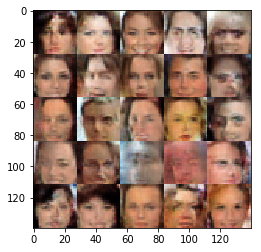

Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.9671


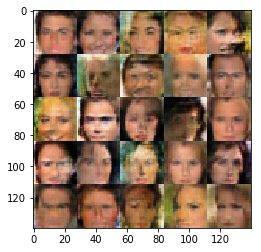

Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 1.1116
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.2489
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.6134... Generator Loss: 0.5166
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.6464


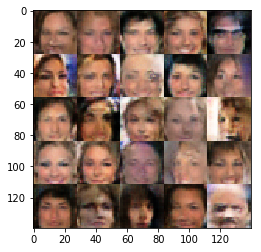

Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 1.0307
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.6637


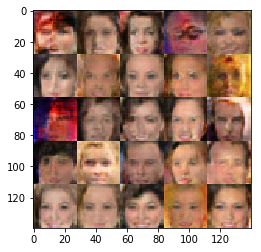

Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.4274
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.5194


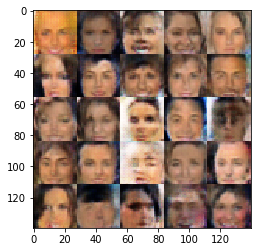

Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.5933
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.6275


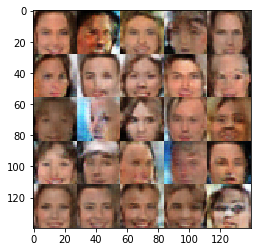

Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 1.3353
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.4637
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.5222
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.0482
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.8211


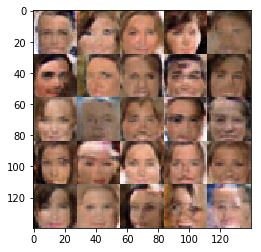

Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 0.9638
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 0.4721
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 1.0944
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.5871


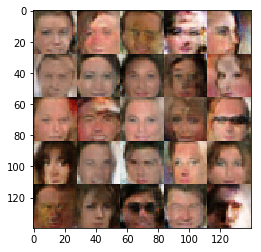

Epoch 1/1... Discriminator Loss: 1.7283... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.4991
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 1.1762
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6589


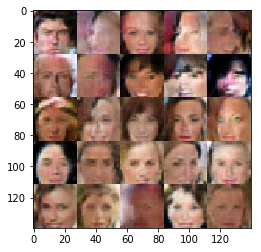

Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 1.2913
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.4762
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.9786


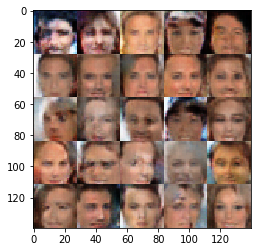

Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.9098


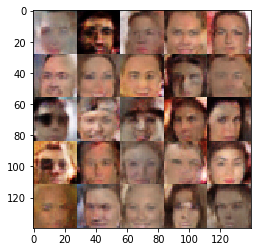

Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.2079
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 1.2739
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 1.3029


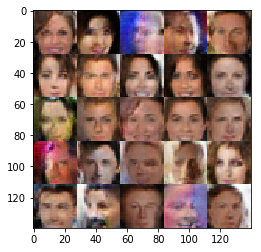

Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.4881
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 1.0359


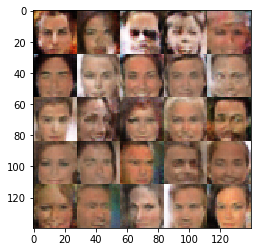

Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.4846


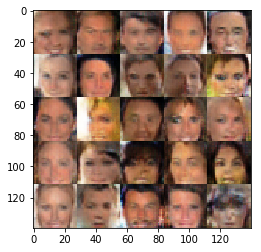

Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 1.2222
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.4925
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.8180


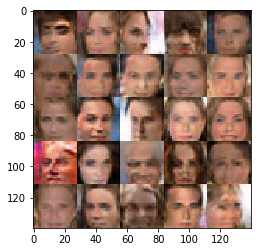

Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.4480


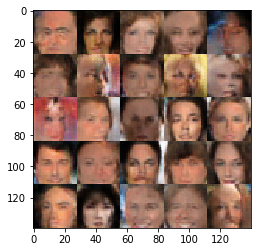

Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.6657... Generator Loss: 0.4501
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.6905


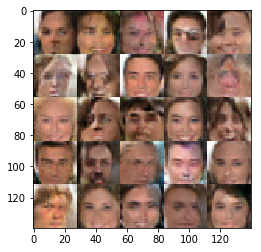

Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.4818
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 1.0468
Epoch 1/1... Discriminator Loss: 1.6077... Generator Loss: 0.4585
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.6582


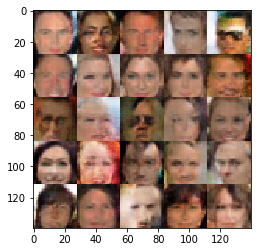

Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.6851


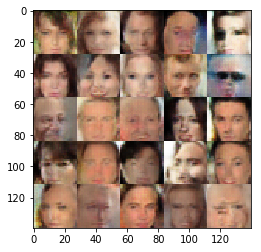

Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.2244
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.5821
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.7406


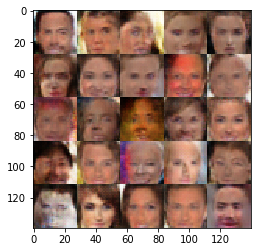

Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 0.5168
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.4998
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.8043


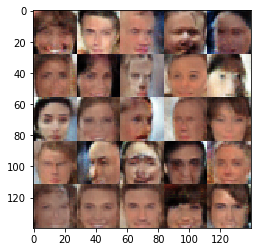

Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 1.1265
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.6389


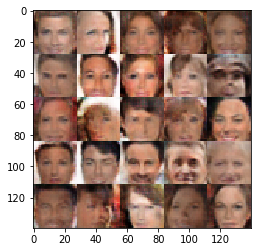

Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.5933
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.6541


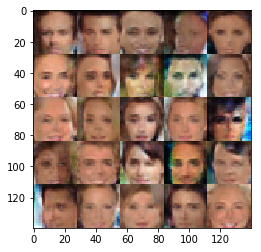

Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.4576
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.4536
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.8898


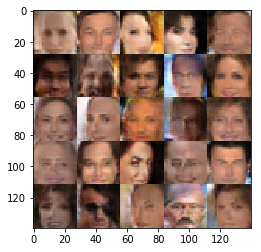

Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.5045
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.7145... Generator Loss: 0.3912
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.4778


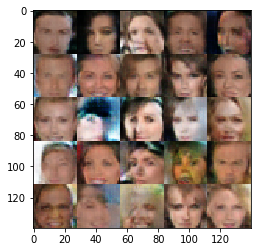

Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.5855... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.7958


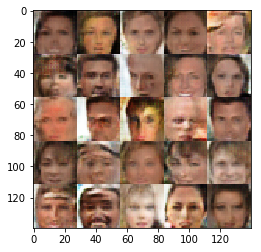

Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.0813
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.5791


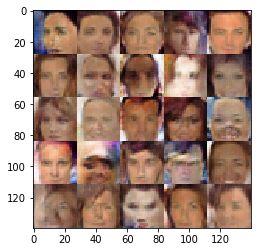

Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.1040
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.5334
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.5810


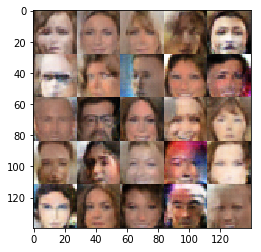

Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.5071
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 0.9631
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.7959


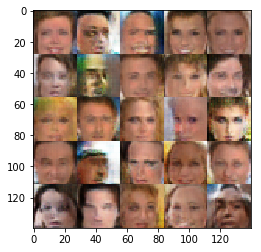

Epoch 1/1... Discriminator Loss: 1.6012... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.4697
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.6539


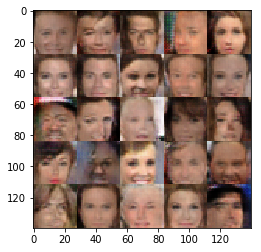

Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.5703


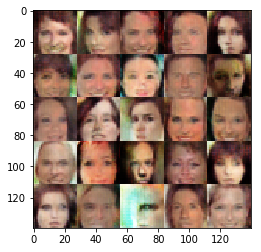

Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.5007
Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.7678


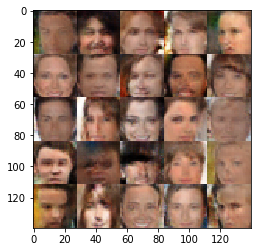

Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6094


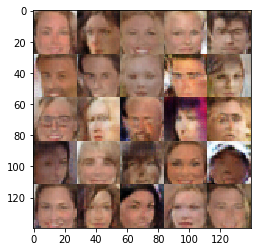

Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.5283


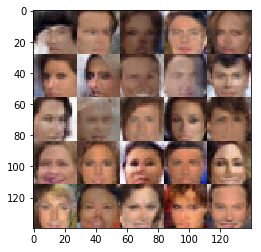

Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 1.0179
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.6821


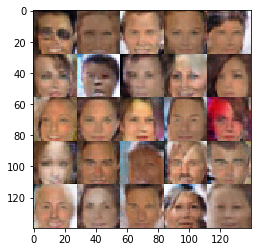

Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.4362
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.6048... Generator Loss: 0.4331
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.4364


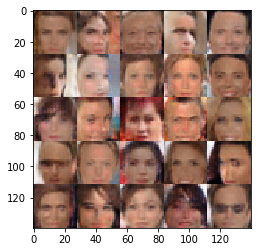

Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 0.9457


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。